See README.md for installs, environment setup

In [1]:
import os
import sys
from multiprocessing import Pool
from datetime import datetime

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import xlrd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# https://www.cvxpy.org/install/index.html
import cvxpy as cp

# https://riskfolio-lib.readthedocs.io/en/latest/
import riskfolio as rp

# set seed for reproducibility
np.random.seed(2347)

print("%-20s %s" % ('python', ".".join(map(str, sys.version_info[:3]))))
print("%-20s %s" % ("numpy", np.__version__))
print("%-20s %s" % ("pandas", pd.__version__))
print("%-20s %s" % ("pandas-datareader", pdr.__version__))
# print("%-20s %s" % ("xlrd", xlrd.__version__))
print("%-20s %s" % ("seaborn", sns.__version__))
print("%-20s %s" % ("matplotlib", matplotlib.__version__))
print("%-20s %s" % ("cvxpy", cp.__version__))
print("%-20s %s" % ("riskfolio", rp.__version__))


python               3.11.11
numpy                2.2.1
pandas               2.2.3
pandas-datareader    0.10.0
seaborn              0.13.2
matplotlib           3.10.0
cvxpy                1.6.0
riskfolio            6.3.1


# Get data

In [2]:
# load spreadsheet from Damodaran website into pandas dataframe

# if below gives cert error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

data_xls = 'https://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
data_sheet = "Returns by year"
# these will change as rows get added on Damodaran website
skiprows = range(19)
skipfooter = 13
download_df = pd.read_excel(data_xls, 
                         sheet_name=data_sheet, 
                         skiprows=skiprows,
                         skipfooter=skipfooter)
download_df


,Year,S&P 500 (includes dividends),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,3-month T.Bill4,US T. Bond5,...,Stocks - Bonds,Stocks - Baa Corp Bond,Historical risk premium,Inflation Rate,S&P 500 (includes dividends)2,3-month T. Bill (Real),!0-year T.Bonds,Baa Corp Bonds,Real Estate3,Gold
0,1928,0.438112,0.030800,0.008355,0.032196,0.014911,0.000969,143.811155,103.080000,100.835471,...,0.429757,0.405916,NaN,-0.011561,0.454932,0.042856,0.020148,0.044268,0.026781,0.012676
1,1929,-0.082979,0.031600,0.042038,0.030179,-0.020568,-0.001452,131.877782,106.337328,105.074397,...,-0.125018,-0.113158,NaN,0.005848,-0.088311,0.025602,0.035980,0.024189,-0.026262,-0.007258
2,1930,-0.251236,0.045500,0.045409,0.005398,-0.043000,0.000969,98.745288,111.175676,109.845753,...,-0.296646,-0.256634,NaN,-0.063953,-0.200079,0.116932,0.116835,0.074090,0.022385,0.069359
3,1931,-0.438375,0.023100,-0.025589,-0.156808,-0.081505,-0.173850,55.457774,113.743835,107.034958,...,-0.412787,-0.281568,NaN,-0.093168,-0.380674,0.128213,0.074522,-0.070178,0.012861,-0.088971
4,1932,-0.086424,0.010700,0.087903,0.235896,-0.104664,0.212778,50.664911,114.960894,116.443660,...,-0.174327,-0.322320,NaN,-0.102740,0.018184,0.126429,0.212472,0.377411,-0.002145,0.351646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2019,0.312117,0.020625,0.096356,0.152478,0.036858,0.190774,502371.389193,2089.670684,8012.888554,...,0.215760,0.159639,0.048254,0.023140,0.282441,-0.002458,0.071561,0.126413,0.013408,0.163843
92,2020,0.180232,0.003547,0.113319,0.106012,0.104321,0.241694,592914.798591,2097.083604,8920.900883,...,0.066913,0.074220,0.048443,0.013220,0.164832,-0.009547,0.098793,0.091581,0.089912,0.225493
93,2021,0.284689,0.000450,-0.044160,0.009334,0.188750,-0.037544,761710.833617,2098.027709,8526.950827,...,0.328849,0.275354,0.051322,0.071945,0.198465,-0.066696,-0.108312,-0.058408,0.108965,-0.102140
94,2022,-0.180375,0.020248,-0.178282,-0.151441,0.056677,0.005494,624317.196856,2140.508136,7006.751407,...,-0.002093,-0.028934,0.050609,0.064449,-0.230001,-0.041525,-0.228034,-0.202819,-0.007302,-0.055386


In [3]:
download_df["Year"] = download_df["Year"].astype(int)
download_df.set_index(download_df["Year"], inplace=True)
download_df


,Year,S&P 500 (includes dividends),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,3-month T.Bill4,US T. Bond5,...,Stocks - Bonds,Stocks - Baa Corp Bond,Historical risk premium,Inflation Rate,S&P 500 (includes dividends)2,3-month T. Bill (Real),!0-year T.Bonds,Baa Corp Bonds,Real Estate3,Gold
Year,,,,,,,,,,,,,,,,,,,,,
1928,1928,0.438112,0.030800,0.008355,0.032196,0.014911,0.000969,143.811155,103.080000,100.835471,...,0.429757,0.405916,NaN,-0.011561,0.454932,0.042856,0.020148,0.044268,0.026781,0.012676
1929,1929,-0.082979,0.031600,0.042038,0.030179,-0.020568,-0.001452,131.877782,106.337328,105.074397,...,-0.125018,-0.113158,NaN,0.005848,-0.088311,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,1930,-0.251236,0.045500,0.045409,0.005398,-0.043000,0.000969,98.745288,111.175676,109.845753,...,-0.296646,-0.256634,NaN,-0.063953,-0.200079,0.116932,0.116835,0.074090,0.022385,0.069359
1931,1931,-0.438375,0.023100,-0.025589,-0.156808,-0.081505,-0.173850,55.457774,113.743835,107.034958,...,-0.412787,-0.281568,NaN,-0.093168,-0.380674,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,1932,-0.086424,0.010700,0.087903,0.235896,-0.104664,0.212778,50.664911,114.960894,116.443660,...,-0.174327,-0.322320,NaN,-0.102740,0.018184,0.126429,0.212472,0.377411,-0.002145,0.351646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,2019,0.312117,0.020625,0.096356,0.152478,0.036858,0.190774,502371.389193,2089.670684,8012.888554,...,0.215760,0.159639,0.048254,0.023140,0.282441,-0.002458,0.071561,0.126413,0.013408,0.163843
2020,2020,0.180232,0.003547,0.113319,0.106012,0.104321,0.241694,592914.798591,2097.083604,8920.900883,...,0.066913,0.074220,0.048443,0.013220,0.164832,-0.009547,0.098793,0.091581,0.089912,0.225493
2021,2021,0.284689,0.000450,-0.044160,0.009334,0.188750,-0.037544,761710.833617,2098.027709,8526.950827,...,0.328849,0.275354,0.051322,0.071945,0.198465,-0.066696,-0.108312,-0.058408,0.108965,-0.102140


In [4]:
# add GDP to correlation matrix
series = ['GDPCA']

gdp_download = pdr.data.DataReader(series, 
                                   'fred', 
                                   start='1926-12-31')
gdp_download.reset_index(inplace=True)
gdp_download.set_index(pd.DatetimeIndex(gdp_download['DATE']).year, inplace=True)
gdp_download['GDP'] = gdp_download['GDPCA'].pct_change()
# https://fortunly.com/statistics/us-gdp-by-year-guide/#gref
gdp_download.loc[1928, 'GDP'] = 0.0110
gdp_download.loc[1929, 'GDP'] = 0.0652
gdp_download.sort_index(inplace=True)
gdp_download.to_csv('gdp_fred.csv')

gdp_download

,DATE,GDPCA,GDP
DATE,,,
1928,NaT,NaN,0.011000
1929,1929-01-01,1191.124,0.065200
1930,1930-01-01,1089.785,-0.085078
1931,1931-01-01,1019.977,-0.064057
1932,1932-01-01,888.414,-0.128986
...,...,...,...
2019,2019-01-01,20715.671,0.025838
2020,2020-01-01,20267.585,-0.021630
2021,2021-01-01,21494.798,0.060551


In [5]:
real_data_df = download_df.copy()
real_data_df.columns

Index(['Year', 'S&P 500 (includes dividends)', '3-month T.Bill',
       'US T. Bond (10-year)', ' Baa Corporate Bond', 'Real Estate', 'Gold*',
       'S&P 500 (includes dividends)3', '3-month T.Bill4', 'US T. Bond5',
       ' Baa Corporate Bond2', 'Real Estate2', 'Gold2', 'Stocks - Bills',
       'Stocks - Bonds', 'Stocks - Baa Corp Bond', 'Historical risk premium',
       'Inflation Rate', 'S&P 500 (includes dividends)2',
       '3-month T. Bill (Real)', '!0-year T.Bonds', 'Baa Corp Bonds',
       'Real Estate3', 'Gold'],
      dtype='object')

In [6]:
# use caution to grab real return columns, not nominal, column names are similar 
real_data_df = download_df.copy()
real_data_df = real_data_df.drop(columns=["Real Estate"])
real_data_df = real_data_df.rename(columns = {'Inflation Rate': 'CPI',
           'S&P 500 (includes dividends)2': 'S&P',
           'Real Estate3': 'Real Estate',
           '3-month T. Bill (Real)': 'T-Bills',
           '!0-year T.Bonds': 'T-Notes',
           'Baa Corp Bonds': 'Baa Corps',
          })
real_data_df["GDP"] = gdp_download['GDP']
# filter and reorder
real_data_df = real_data_df[['GDP', 'CPI', 'S&P', 'Real Estate', 'T-Bills', 'T-Notes', 'Gold', 'Baa Corps',]]
real_data_df


,GDP,CPI,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps
Year,,,,,,,,
1928,0.011000,-0.011561,0.454932,0.026781,0.042856,0.020148,0.012676,0.044268
1929,0.065200,0.005848,-0.088311,-0.026262,0.025602,0.035980,-0.007258,0.024189
1930,-0.085078,-0.063953,-0.200079,0.022385,0.116932,0.116835,0.069359,0.074090
1931,-0.064057,-0.093168,-0.380674,0.012861,0.128213,0.074522,-0.088971,-0.070178
1932,-0.128986,-0.102740,0.018184,-0.002145,0.126429,0.212472,0.351646,0.377411
...,...,...,...,...,...,...,...,...
2019,0.025838,0.023140,0.282441,0.013408,-0.002458,0.071561,0.163843,0.126413
2020,-0.021630,0.013220,0.164832,0.089912,-0.009547,0.098793,0.225493,0.091581
2021,0.060551,0.071945,0.198465,0.108965,-0.066696,-0.108312,-0.102140,-0.058408


In [7]:
real_data_df.mean()

GDP            0.033049
CPI            0.031191
S&P            0.084038
Real Estate    0.012786
T-Bills        0.003152
T-Notes        0.018600
Gold           0.032740
Baa Corps      0.038964
dtype: float64

In [8]:
# check gold data v MacroTrends
# gdf = pd.read_csv('MacroTrends_Data_Download.csv')
# gdf["Year"] = pd.to_datetime(gdf['date'])
# gdf = gdf.loc[gdf["Year"].dt.month ==12]
# gdf["Year"] = gdf["Year"].dt.year
# gdf = gdf.set_index("Year", drop=True)
# gdf['real_pct'] = gdf["real"].pct_change()
# gdf['nom_pct'] = gdf["nominal"].pct_change()
# gdf["damodaran_real_pct"]=download_df["Gold"]
# gdf["damodaran_nom_pct"]=download_df["Gold*"]
# gdf["real_diff"] = gdf["damodaran_real_pct"]-gdf["real_pct"]
# gdf["nom_diff"] = gdf["damodaran_nom_pct"]-gdf["nom_pct"]
# gdf[["nom_diff", 'real_diff']].plot()

# Visualize

In [9]:
pd.set_option('display.max_rows', None)  # This will display all rows without truncation


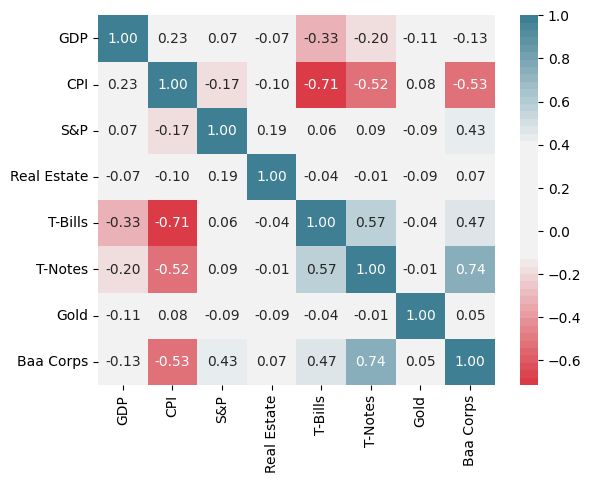

In [10]:
for col in real_data_df.columns:
    real_data_df[col] = real_data_df[col].astype(float)

# compute correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(real_data_df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [11]:
# drop CPI, GDP which are not assets
try:
    real_data_df.drop(labels=['CPI', 'GDP'], axis=1, inplace=True)
except:
    pass
    
df = real_data_df.copy()
df


,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps
Year,,,,,,
1928,0.454932,0.026781,0.042856,0.020148,0.012676,0.044268
1929,-0.088311,-0.026262,0.025602,0.035980,-0.007258,0.024189
1930,-0.200079,0.022385,0.116932,0.116835,0.069359,0.074090
1931,-0.380674,0.012861,0.128213,0.074522,-0.088971,-0.070178
1932,0.018184,-0.002145,0.126429,0.212472,0.351646,0.377411
1933,0.488460,-0.045406,0.001952,0.010836,0.262955,0.121111
1934,-0.026634,0.013703,-0.012184,0.063520,0.297844,0.170431
1935,0.424871,0.065842,-0.027359,0.014439,-0.024787,0.100235
1936,0.300585,0.017440,-0.012585,0.035176,-0.013437,0.097926


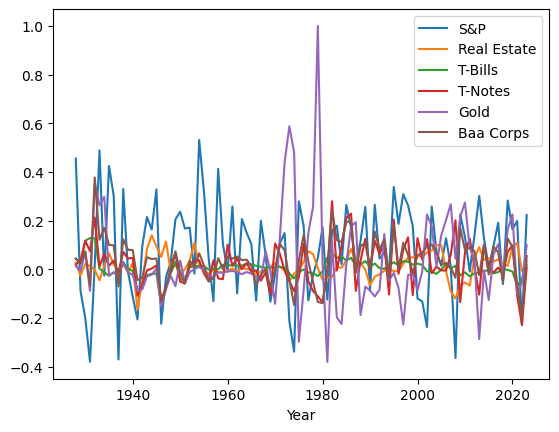

In [12]:
df.plot.line();


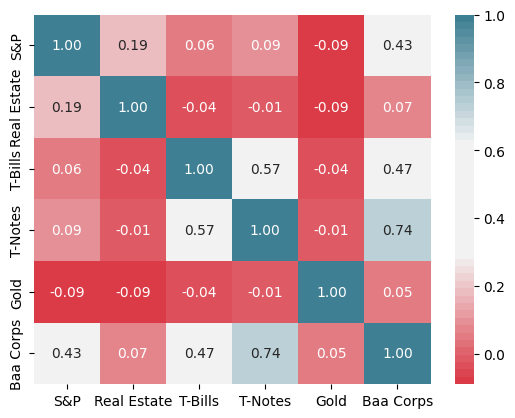

In [13]:
# compute correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [14]:
# plot historical cumulative growth
df2 = df.copy()
for col in df2.columns:
    df2[col]+= 1
    df2[col] = df2[col].cumprod()
    

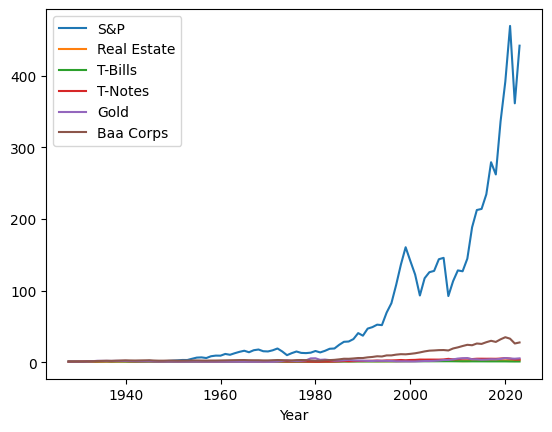

In [15]:
df2.plot.line();


In [16]:
df2.loc[1967:]

,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps
Year,,,,,,
1967,16.969872,1.467311,1.002213,1.415166,0.861966,2.987684
1968,17.959966,1.459295,1.008259,1.395821,0.925923,2.991658
1969,15.561844,1.474391,1.015586,1.251981,0.918164,2.767802
1970,15.265681,1.511334,1.023482,1.384620,0.787550,2.769881
1971,16.885113,1.525656,1.034066,1.472049,0.889950,3.057826
1972,19.391441,1.519303,1.040621,1.463680,1.280494,3.294476
1973,15.253097,1.442333,1.022417,1.392707,2.032953,3.154668
1974,10.082760,1.416322,0.983660,1.267142,3.013238,2.690994
1975,12.893688,1.411623,0.971331,1.225461,2.115193,2.789483


In [17]:
# plot historical cumulative growth since 1970
df2 = df.copy().loc[1970:]
for col in df2.columns:
    df2[col]+= 1
    df2[col] = df2[col].cumprod()

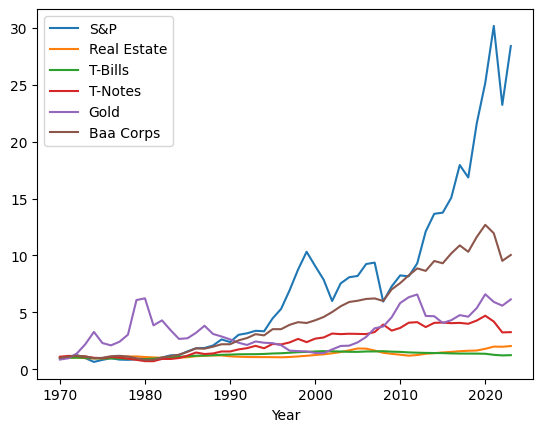

In [18]:
df2.plot.line();


In [19]:
# drop T-Notes, allocations are small, favors corps 
# df.drop(labels=['T-Notes'], axis=1, inplace=True)

labels = list(df.columns)
labels


['S&P', 'Real Estate', 'T-Bills', 'T-Notes', 'Gold', 'Baa Corps']

# Long-only optimization

## 1928 - present (post gold standard)

In [20]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps
rows,,,,,,
real return,0.084038,0.012786,0.003152,0.018600,0.032740,0.038964
vol,0.194252,0.050148,0.038128,0.089091,0.186123,0.088539


In [21]:
w

Variable((6,), var1)

In [22]:
Sigma

array([[ 3.77339783e-02,  1.82717229e-03,  4.25839506e-04,
         1.59912623e-03, -3.28244157e-03,  7.45327290e-03],
       [ 1.82717229e-03,  2.51480361e-03, -7.84119166e-05,
        -2.82273270e-05, -8.12252496e-04,  3.28034130e-04],
       [ 4.25839506e-04, -7.84119166e-05,  1.45371348e-03,
         1.93692299e-03, -2.77414772e-04,  1.59618376e-03],
       [ 1.59912623e-03, -2.82273270e-05,  1.93692299e-03,
         7.93712689e-03, -1.53433076e-04,  5.81440960e-03],
       [-3.28244157e-03, -8.12252496e-04, -2.77414772e-04,
        -1.53433076e-04,  3.46418353e-02,  7.65093629e-04],
       [ 7.45327290e-03,  3.28034130e-04,  1.59618376e-03,
         5.81440960e-03,  7.65093629e-04,  7.83913387e-03]])

In [23]:
# Solve max return portfolio (corner solution)
# should be 100% stocks
prob = cp.Problem(cp.Maximize(ret),      # maximize return
                  [cp.sum(w) == 1,       # weights sum to 1
                   w >= 0]               # each w > 0
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps
0,1.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# solve min vol portfolio (other corner solution)
# should be mostly T-bills but there is variance in t-bills so it diversifies
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1,     # weights sum to 1
                   w >= 0],            # each weight >= 0
                 )
prob.solve()
# round to not get x.xxxxE-22
wts = [float('%0.6f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps
0,0.001076,0.361574,0.599897,-0.0,0.037453,-0.0


In [25]:
# %%time
# solve points in between
# for a series of points between min and max vol, maximize return subject to volatility constraints 

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


In [26]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
# ret_df


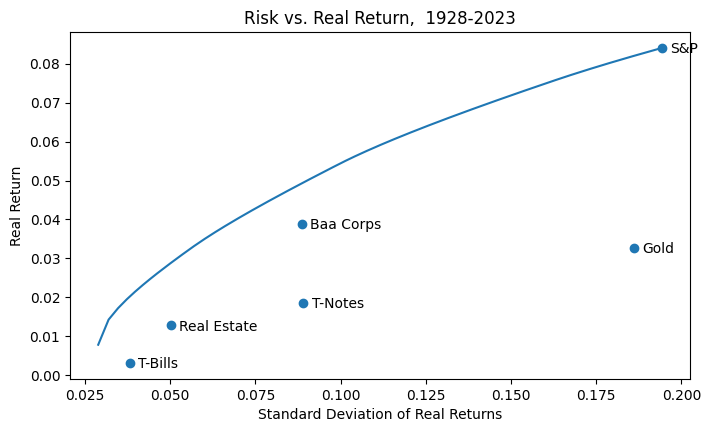

In [27]:
# plot efficient frontier
def plot_efrontier(ret_df, df,
                   xlabel="Standard Deviation of Real Returns",
                   ylabel="Real Return",
                   title=None):

    Sigma = np.cov(df.transpose())
    n = Sigma.shape[0]
    mu = df.mean().values
    asset_vols = np.sqrt(Sigma.diagonal())

    plt.figure(figsize=(8, 4.5))

    # plot the data
    plt.plot(ret_df['std'], ret_df['return'])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plot_title = "Risk vs. Real Return,  %d-%d" % (df.index[0], df.index[-1]) if title is None else title
    plt.title(plot_title)

    # plot the markers
    plt.scatter(asset_vols, mu)
    xoffset = 0.0025
    yoffset = 0.0015
    labels = df.columns
    for i, label in enumerate(labels):
        plt.annotate(label, xy=(asset_vols[i]+xoffset, mu[i]+yoffset),  xycoords='data',
                     horizontalalignment='left', verticalalignment='top',
                    )
        
        
plot_efrontier(ret_df, df)


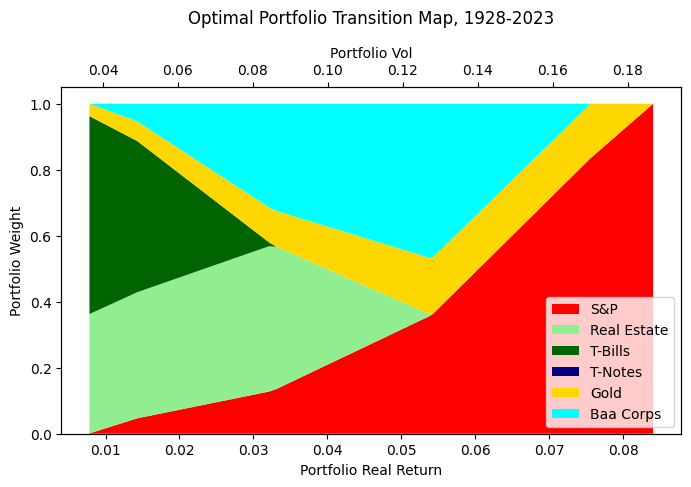

In [28]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights
def transition_map(ret_df, labels, startyear, endyear):
    
    x = ret_df['return']
    # absolute values so shorts don't create chaos
    y_list = [abs(ret_df[l]) for l in labels]
    pal = ['red', 'lightgreen', 'darkgreen', 'navy', 'gold', 'cyan']
    
    fig = plt.figure(figsize=(8, 4.5))
    ax1 = fig.add_subplot(111)

    ax1.stackplot(x, y_list, labels=labels, colors=pal)
    ax1.set_xlabel("Portfolio Real Return")
    ax1.set_ylabel("Portfolio Weight")
    ax1.legend(loc='lower right')
    ax2 = ax1.twiny()
    ax2.set_xlim((ret_df['std'].iloc[0], ret_df['std'].iloc[-1]))
    ax2.set_xlabel('Portfolio Vol')
    
    
    plt.title("Optimal Portfolio Transition Map, %d-%d" % (startyear, endyear), y=1.16);

transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])


## 1967 - present (post gold standard)

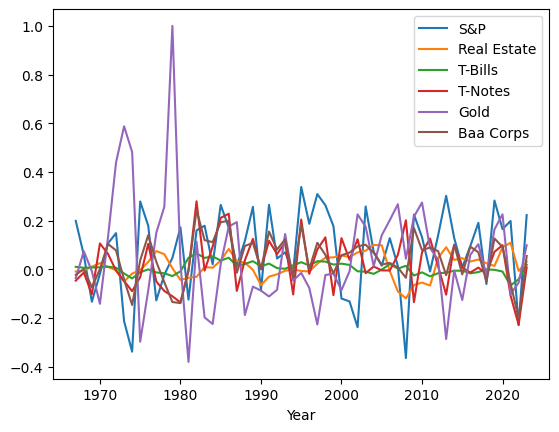

In [29]:
df = real_data_df.loc[1967:]
df.plot.line();


In [30]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps
rows,,,,,,
real return,0.076407,0.013716,0.004536,0.023099,0.054317,0.043493
vol,0.167233,0.049529,0.024978,0.103915,0.226257,0.090850


In [31]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps
0,1.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps
0,0.0,0.2108,0.7478,-0.0,0.0413,-0.0


In [33]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 74.4 ms, sys: 902 μs, total: 75.3 ms
Wall time: 76.1 ms


In [34]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
# ret_df

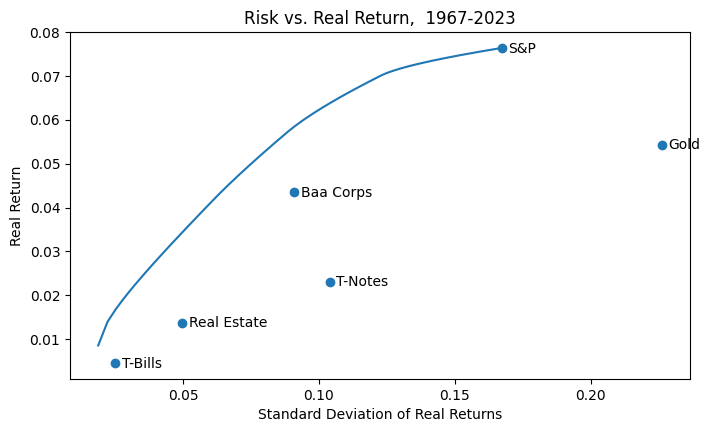

In [35]:
plot_efrontier(ret_df, df)


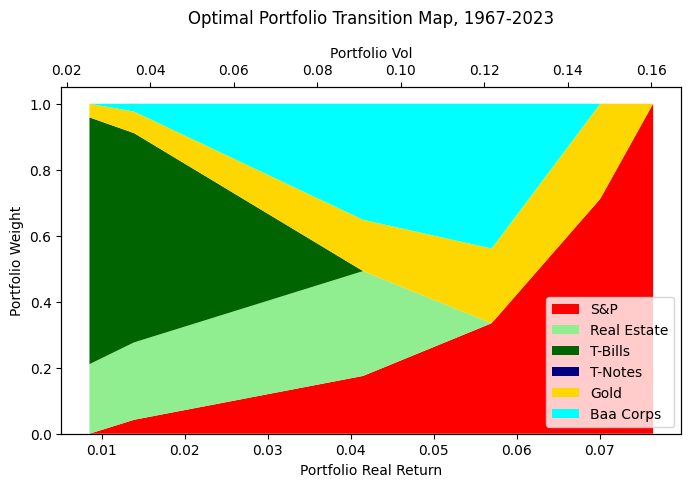

In [36]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])

## 1983 - present (post-inflation era)


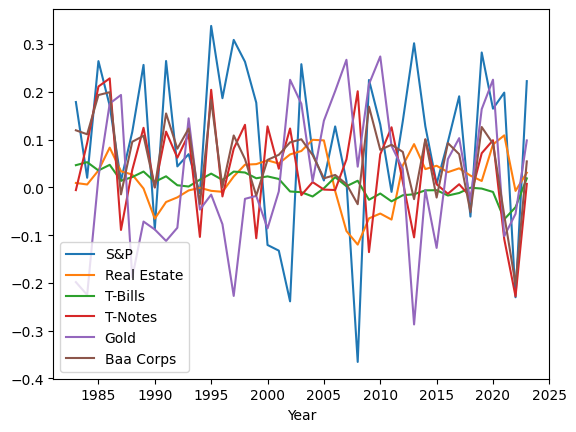

In [37]:
df = real_data_df.loc[1983:]
df.plot.line();

In [38]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps
rows,,,,,,
real return,0.097264,0.018725,0.005704,0.036572,0.019288,0.060114
vol,0.162519,0.053706,0.024841,0.101244,0.146700,0.079698


In [39]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps
0,1.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps
0,0.0,0.1895,0.7527,-0.0,0.0578,-0.0


In [41]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 77 ms, sys: 1.33 ms, total: 78.3 ms
Wall time: 77.8 ms


In [42]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
# ret_df


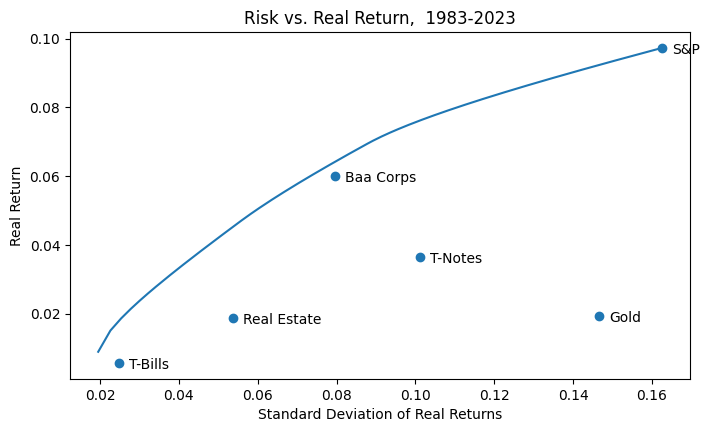

In [43]:
plot_efrontier(ret_df, df)


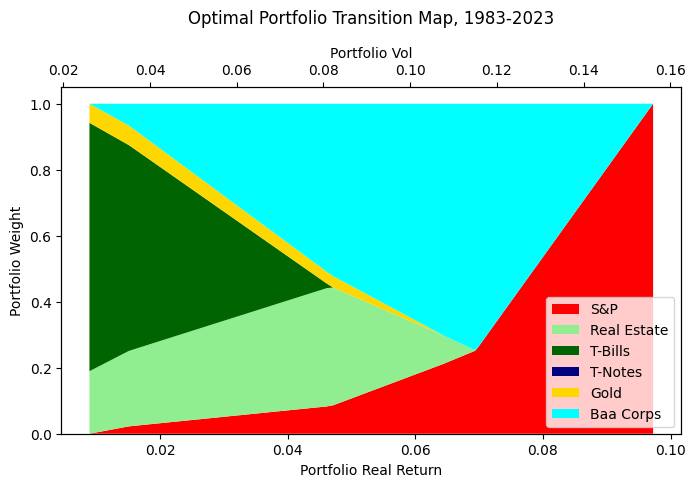

In [44]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])

## Risk assets only, 1983 - present (post-inflation era)


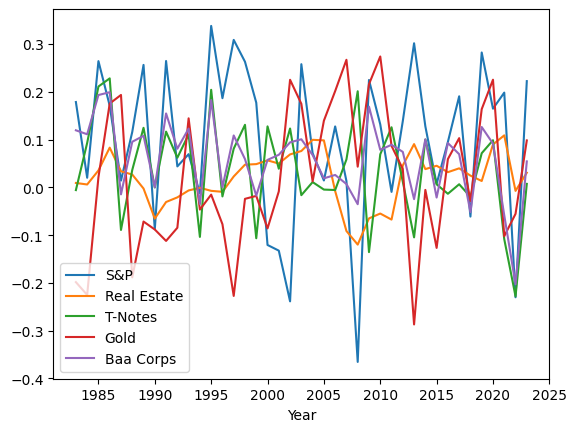

In [45]:
# only risk assets
df = real_data_df.loc[1983:].copy()
df = df.drop(columns=["T-Bills",])
labels = df.columns
df.plot.line();

In [46]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Real Estate,T-Notes,Gold,Baa Corps
rows,,,,,
real return,0.097264,0.018725,0.036572,0.019288,0.060114
vol,0.162519,0.053706,0.101244,0.146700,0.079698


In [47]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,Real Estate,T-Notes,Gold,Baa Corps
0,1.0,0.0,0.0,0.0,0.0


In [48]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,Real Estate,T-Notes,Gold,Baa Corps
0,0.0,0.6562,0.1372,0.0848,0.1219


In [49]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 73.8 ms, sys: 976 μs, total: 74.8 ms
Wall time: 74.8 ms


In [50]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
# ret_df


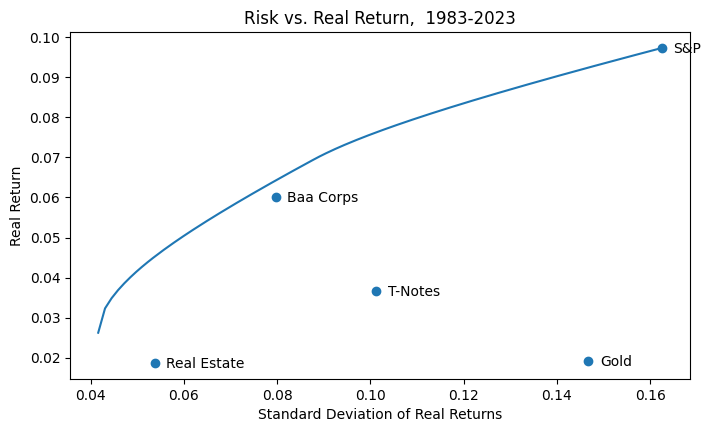

In [51]:
plot_efrontier(ret_df, df)


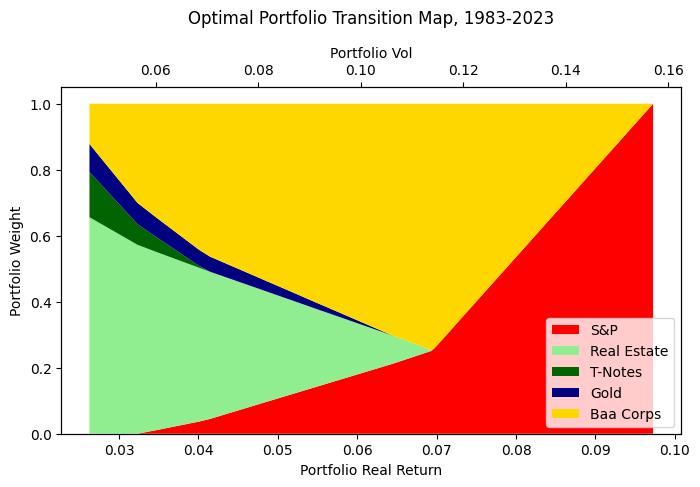

In [52]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])

## Add a risk-free asset
- The efficient frontier above does not include a risk-free asset, when we inflation-adjust t-bill returns we get volatility and fluctuation in returns including periods of negative real returns.
- However TIPS are available which offer a guaranteed real return (before taxes). they are issued at a real rate, the principal gets adjusted for inflation, and if there is deflation you can't get back less than par. So when you buy TIPS you are guaranteed a positive real return
- TIPS offer an inflation hedge and a safe real return, so they might dominate gold. There isn't a great theoretical argument gold should increase in value much faster than inflation in the long run (gold bugs might disagree). I could see reasonable arguments why gold should maintain its real value, and there should be demand for gold when there is inflation and people lose faith in monetary authorities, so gold offers an inflation hedge. 
- However, TIPS total returns are only available for approximately the last 25 years. You can model the TIPS yield as the yield on similar nominal Treasuries less inflation expectations. There might be a credible way to model historical inflation expectations using recent inflation trends, gold etc. And from there, model what TIPS total returns would theoretically have been based on Treasury total returns and changes in inflation expectations. But that is a tough nut to crack.
- But given the existence of TIPS, a risk-free 0 real yield asset is a given, you could buy TIPS and donate any return over 0, and you are guaranteed return of principal plus inflation, with no fluctuations in returns.
- So we are justified in adding a risk-free TIPS asset, with a constant zero return.
- In the real world you would get a positive real return on TIPS with some fluctuations, real TIPS should dominate the risk-free asset, so it might underweight TIPS in this model.


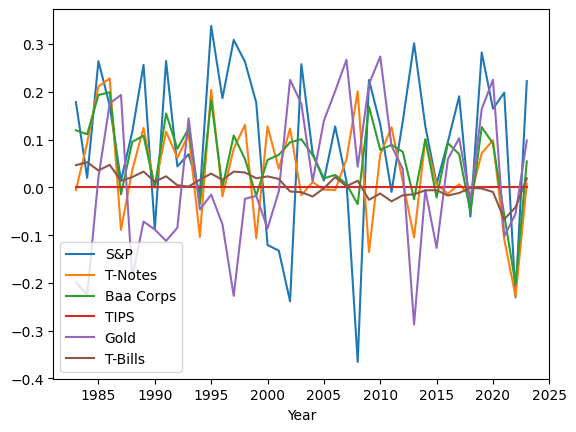

In [53]:
df = real_data_df.loc[1983:].copy()
df["TIPS"] = 0
# reorder  for chart
df = df[[ 'S&P', 'T-Notes', 'Baa Corps', 'TIPS', 'Gold', 'T-Bills' ]]
labels = df.columns
df.plot.line();

In [54]:
# compute covariance matrix
Sigma = np.cov(df.transpose())

# number of assets
n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 

# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Notes,Baa Corps,TIPS,Gold,T-Bills
rows,,,,,,
real return,0.097264,0.036572,0.060114,0.0,0.019288,0.005704
vol,0.162519,0.101244,0.079698,0.0,0.146700,0.024841


In [55]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,T-Notes,Baa Corps,TIPS,Gold,T-Bills
0,1.0,0.0,0.0,0.0,0.0,0.0


In [56]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)



Min vol portfolio weights


,S&P,T-Notes,Baa Corps,TIPS,Gold,T-Bills
0,-0.0,-0.0,-0.0,1.0,0.0,-0.0


In [57]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 76.9 ms, sys: 1.01 ms, total: 77.9 ms
Wall time: 78.2 ms


In [58]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
# ret_df



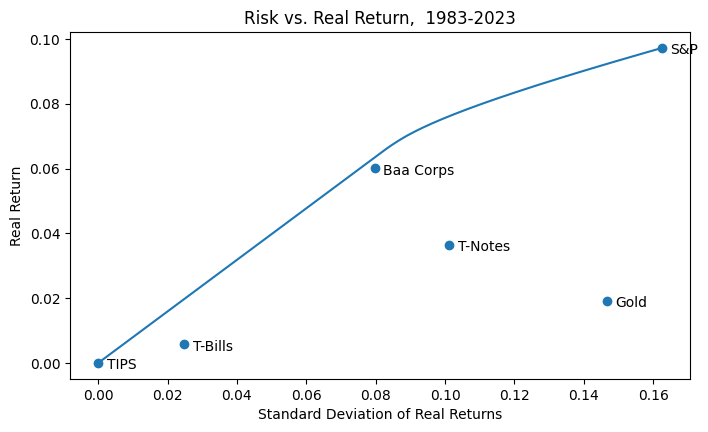

In [59]:
plot_efrontier(ret_df, df)


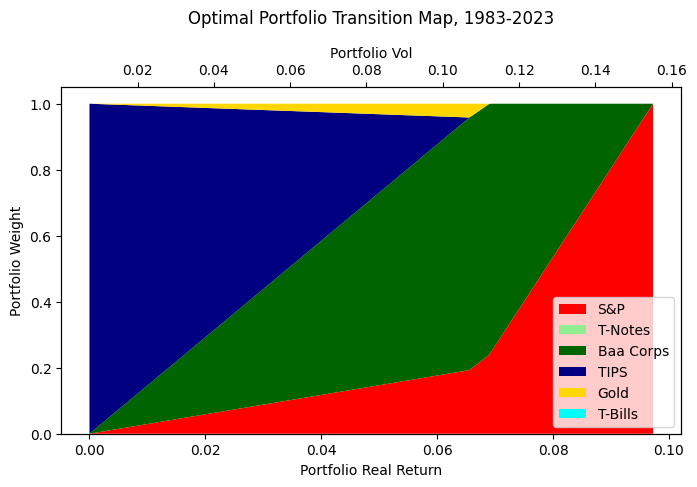

In [60]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])

# Long/short optimization with leverage constraint

In [61]:
x1 = real_data_df['S&P'].values
n = len(x1)
target_corr = 0.6
theta = np.arccos(target_corr)
mean_return = -0.05
x2 = np.random.normal(0, x1.std(), size=n)  
# center so actual mean = 0
X = pd.DataFrame({'x1': x1 - x1.mean(),
                  'x2': x2 - x2.mean()
                 })
# identity matrix
Id = np.diag(np.ones(n))
# QR factorization 
Q, R = np.linalg.qr(X[['x1']])
P = Q @ Q.T
x2o = (Id - P) @ X[['x2']]
Xc2 = pd.DataFrame({'x1': X['x1'], 'x2': x2o['x2']})
# divide by l2 norm
Y = Xc2 / np.sqrt(np.sum(np.square(Xc2), axis=0))
retval = Y['x2'] + (1/np.tan(theta)) * Y['x1'] + mean_return


In [62]:
# in order to include shorts, we need an asset with a poor expected return
# assume I can identify bad stocks, they are highly correlated with S&P but return negative 5%
# create a synthetic 'shorts' asset 

n = len(real_data_df)
target_corr = 0.6
def target_corr(x1, target_corr, mean_return):
    """given a series x1, return a random series with correlation target_corr to x1"""
    n = len(x1)
    theta = np.arccos(target_corr)
    
    x2 = np.random.normal(0, x1.std(), size=n)  
    # center so actual mean = 0
    X = pd.DataFrame({'x1': x1 - x1.mean(),
                      'x2': x2 - x2.mean()
                     })
    # identity matrix
    Id = np.diag(np.ones(n))
    # QR factorization
    Q = np.linalg.qr(X[['x1']])[0]
    P = Q @ Q.T
    x2o = (Id - P) @ X[['x2']]
    Xc2 = pd.DataFrame({'x1': X['x1'], 'x2': x2o['x2']})
    # divide by l2 norm
    Y = Xc2 / np.sqrt(np.sum(np.square(Xc2), axis=0))
    return Y['x2'] + (1/np.tan(theta)) * Y['x1'] + mean_return

shorts = target_corr(real_data_df['S&P'].values, 0.9, -0.05)
print("mean return %.04f" % shorts.mean())
print("vol %.04f" % shorts.std())
np.corrcoef(shorts, real_data_df['S&P'])



mean return -0.0500
vol 0.2354


array([[1. , 0.9],
       [0.9, 1. ]])

In [63]:
real_data_df.columns

Index(['S&P', 'Real Estate', 'T-Bills', 'T-Notes', 'Gold', 'Baa Corps'], dtype='object')

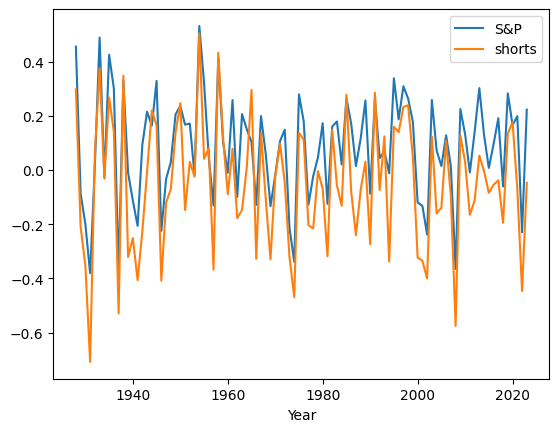

In [64]:
df = real_data_df.copy()
df['shorts'] = shorts.to_list()
labels = ['S&P', 'Real Estate', 'T-Bills', 'T-Notes', 'Gold', 'Baa Corps', 'shorts']

df[['S&P', 'shorts']].plot.line();

In [65]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps,stonks
rows,,,,,,,
real return,0.084038,0.012786,0.003152,0.018600,0.032740,0.038964,-0.050000
vol,0.194252,0.050148,0.038128,0.089091,0.186123,0.088539,0.235376


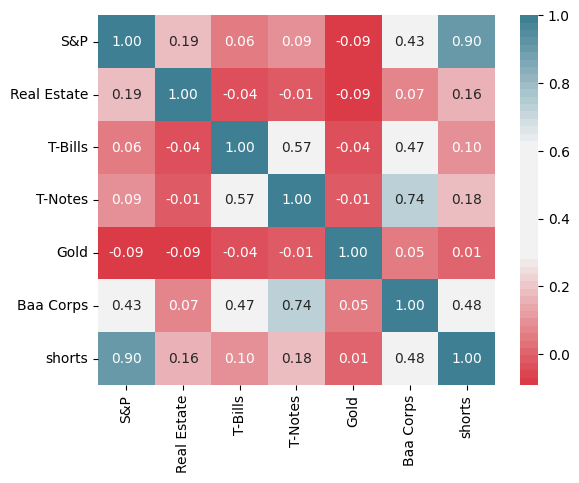

In [66]:
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [67]:
# Solve max return portfolio (corner solution)
# update constraints for leverage scenario
# sum of weights == 1 as before, net long 100%
# remove w >= 0 constraint
# new constraint on gross exposure <= 1.5, otherwise optimal weights are unbounded (go infinity long S&P, infinity short stonks)

prob = cp.Problem(cp.Maximize(ret), 
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights (return=%.4f, vol=%.4f)" % (maxret, maxretvol))
pd.DataFrame([wts], columns=labels)


Max return portfolio weights (return=0.1175, vol=0.0367)


,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps,stonks
0,1.25,-0.0,-0.0,-0.0,0.0,0.0,-0.25


In [68]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights (return=%.4f, vol=%.4f)" % (minvolret, minvol))
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights (return=0.0118, vol=0.0008)


,S&P,Real Estate,T-Bills,T-Notes,Gold,Baa Corps,stonks
0,0.0443,0.3492,0.6551,-0.0308,0.0415,-0.0248,-0.0344


In [69]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret), 
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1,
                   vol <= vol_limit]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 90.3 ms, sys: 4.25 ms, total: 94.6 ms
Wall time: 91.6 ms


In [70]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
# ret_df


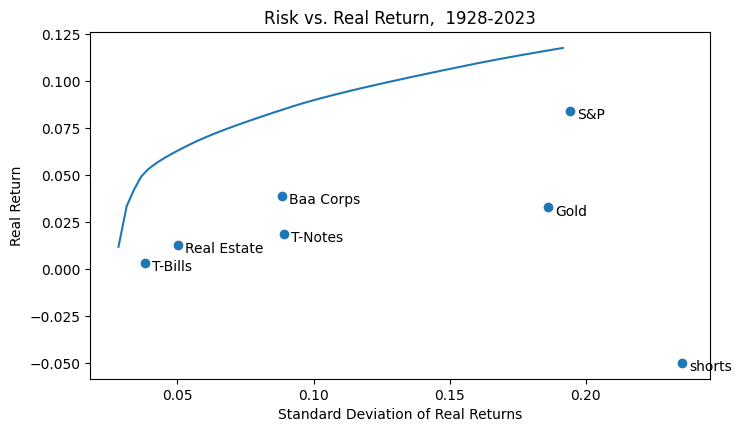

In [71]:
plot_efrontier(ret_df, df)


In [79]:
transition_map(ret_df, labels=labels, startyear=df.index[0], endyear=df.index[-1])
# these are absolute values, there are shorts

KeyError: 'shorts'

# Hierarchical risk parity
- Using the correlation matrix we can cluster assets into similar clusters and put equal risk into each cluster
  - Start off with 2 clusters, minimizing between-cluster correlation while maximizing within-cluster correlation
  - Invest 50% in each cluster
  - Recursively partition each cluster in the same way, until all clusters have a single asset
  - A heuristic way to create a low variance portfolio, but unlike the minimum-variance optimization it's not very sensitive to small changes in correlations
    

In [ ]:
## 1928-present
df = real_data_df.loc[1928:].copy()
df = df.drop(columns=['T-Bills', 'Real Estate'])   # will be overweighted b/c low risk
# reorder  for chart
labels = df.columns
df.plot.line();

In [ ]:
# Building the portfolio object
port = rp.HCPortfolio(returns=df)

# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

display(w.T)


In [ ]:
# 1967-present
df = df.loc[1967:]
# reorder  for chart
labels = df.columns

# Building the portfolio object
port = rp.HCPortfolio(returns=df)

# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)
display(w.T)


In [ ]:
# 1982-present
df = df.loc[1982:]
labels = df.columns

# Building the portfolio object
port = rp.HCPortfolio(returns=df)

# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)
display(w.T)

In [ ]:
# Building the portfolio object
port = rp.HCPortfolio(returns=df)

# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)
display(w.T)



# Factors

In [ ]:
# we do this experiment with a synthetic portfolio
# number of stocks
n = 1000 
# historical mean returns for each stock
mu = np.random.normal(0.1, 0.2, n)

# number of factors
m = 10

# factor covariance matrix - random symmetrical matrix
SigmaFactor = np.random.randn(m, m)/4
SigmaFactor = SigmaFactor.T @ SigmaFactor

# factor loadings, determine volatility and covariances between stocks
F = np.random.randn(n, m)
# idiosyncratic risk of each stock
D = np.diag(np.random.uniform(0, 0.9, size=n))

count, bins, ignored = plt.hist(mu, 100, density=True, align='mid')


In [ ]:
w = cp.Variable(n)         # what we solve for: weight for each stock
ret = mu.T @ w             # solve for weights that maximize portfolio return
f = F.T @ w                # portfolio factor loading
Lmax = cp.Parameter()      # leverage constraint
# portfolio volatility: factor risk + idiosyncratic risk
risk = cp.quad_form(f, SigmaFactor) + cp.quad_form(w, D)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
prob.solve(verbose=True)

maxretvol = risk.value
maxret = ret.value
print("Max return portfolio (return=%.4f, vol=%.4f)" % (maxret, maxretvol))


In [ ]:
# solve min vol portfolio (other corner solution)

prob = cp.Problem(cp.Minimize(risk),
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax])
prob.solve(solver=cp.OSQP)

minvol = risk.value
minvolret = ret.value
print("Min vol portfolio (return=%.4f, risk=%.4f)" % (minvolret, minvol))


In [ ]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility
# might have to run a couple of times to get a solution

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax,
                   risk <= vol_limit]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve(verbose=False)
    return (ret.value, np.sqrt(risk.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


In [ ]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'var']
ret_df['return'] = [results_dict[v][0] for v in ret_df['var']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['var']]
# ret_df


In [ ]:
# plot frontier
plt.figure(figsize=(8, 4.5))
#plt.scatter(asset_vols, mu)

x = ret_df['std']
y = ret_df['return']
plt.xlabel("Standard Deviation of Returns")
plt.ylabel("Return")
plt.title("Risk vs. Return")

# plot the data
plt.plot(x,y);


In [ ]:
#TRIALS

In [ ]:
def trial(vol=0,
          startval=1025000,
          spend=50000,
          ret_expected=0.0,
          vol_expected=0.0, 
          verbose=False):

    year = 0
    val = startval
    while val > 0:
        if verbose:
            print("year %-2d: %8.0f" % (year, val))
        ret = np.random.normal(loc=ret_expected,
                               scale=vol_expected)
        val -= spend
        # lognormal distribution
        val = np.exp(np.log(val) + ret) if val > 0 else 0
        val = max(0, val)
        year += 1

    if verbose:
        print("year %-2d: %8.0f" % (year, val))
        
    return(year)

trial(vol_expected=0.0, verbose=True)


In [ ]:
mydf = real_data_df.loc[real_data_df.index > 2002].copy()
mydf

In [ ]:
mydf['raw_return'] = .6* mydf['S&P'] + .35*mydf['Baa Corps'] + 0.05 * mydf['T-Bills']
mydf['tax'] = mydf['raw_return'] * 0.1
mydf['tax'] = mydf['tax'].apply(lambda z: max(z, 0))
mydf['after_tax'] = mydf['raw_return'] - mydf['tax']

mydf

In [ ]:
port = 550000
spend = .02

for year in range(2004, 2023):
    
    r = mydf.loc[mydf.index==year]['after_tax'].tolist()[0]
    port *= (1+r)
    port *= (1-spend)
    print (year, port, r)
